<a href="https://colab.research.google.com/github/mydmitrii/DS_projects/blob/main/Animal_Face_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация лиц животных

# Загрузка и первичное исследование данных

In [ ]:
# импорт библиотек

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# модули библиотеки PyTorch
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision

# метрика качества
from sklearn.metrics import accuracy_score
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активации для слоев нейронных сетей
import torch.nn.functional as F

Загрузим датасет через kaggle api напрямую в colab

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!kaggle datasets download -d andrewmvd/animal-faces

100% 693M/696M [00:34<00:00, 21.4MB/s]
100% 696M/696M [00:34<00:00, 21.4MB/s]


In [ ]:
!unzip animal-faces.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: a

In [ ]:
train_path = "/content/afhq/train"
val_path = "/content/afhq/val"

In [ ]:
# конвертируем в pytorch tensor
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера изображений
    transforms.ToTensor()
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера изображений
    transforms.ToTensor()
])

In [ ]:
# cоздание датасетов
train_dataset = datasets.ImageFolder(train_path, transform=transform_train)
test_dataset = datasets.ImageFolder(val_path, transform=transform_val)

Создадим словарь соответствий номера и названия, чтобы проще интерпретировать выход нейронной сети:

In [ ]:
num_to_name = {
    0: "Кошка",
    1: "Собака",
    2: "Дикое животное",
}

Выведем число элементов каждого класса в train_dataset и test_dataset

In [ ]:
train_class_counts = torch.bincount(torch.tensor(train_dataset.targets))
for i, count in enumerate(train_class_counts):
    class_name = num_to_name[i]
    print(f"Количество элементов класса {class_name} в train_dataset: {count}")

Количество элементов класса Кошка в train_dataset: 5153
Количество элементов класса Собака в train_dataset: 4739
Количество элементов класса Дикое животное в train_dataset: 4738


In [ ]:
test_class_counts = torch.bincount(torch.tensor(test_dataset.targets))
for i, count in enumerate(test_class_counts):
    class_name = num_to_name[i]
    print(f"Количество элементов класса {class_name} в test_dataset: {count}")

Количество элементов класса Кошка в test_dataset: 500
Количество элементов класса Собака в test_dataset: 500
Количество элементов класса Дикое животное в test_dataset: 500


Визуализируем классы в train_dataset

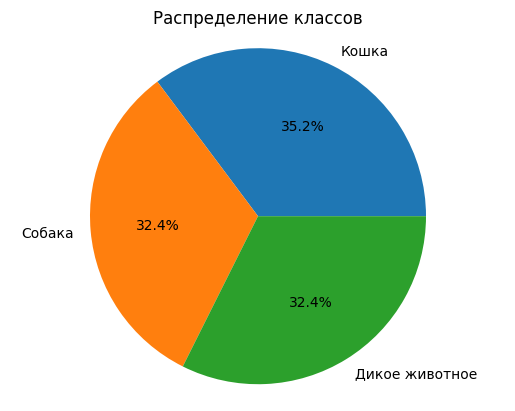

In [ ]:
labels = [num_to_name[i] for i in range(len(train_class_counts))]
sizes = train_class_counts.numpy()

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Распределение классов')
plt.show()

Загрузчики трейн и тест части

In [ ]:
# загрузчики треин и тест части
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle = True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle = False)

In [ ]:
train_loader

In [ ]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам
images, labels = next(dataiter)

In [ ]:
# размер датасета
images.shape, labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

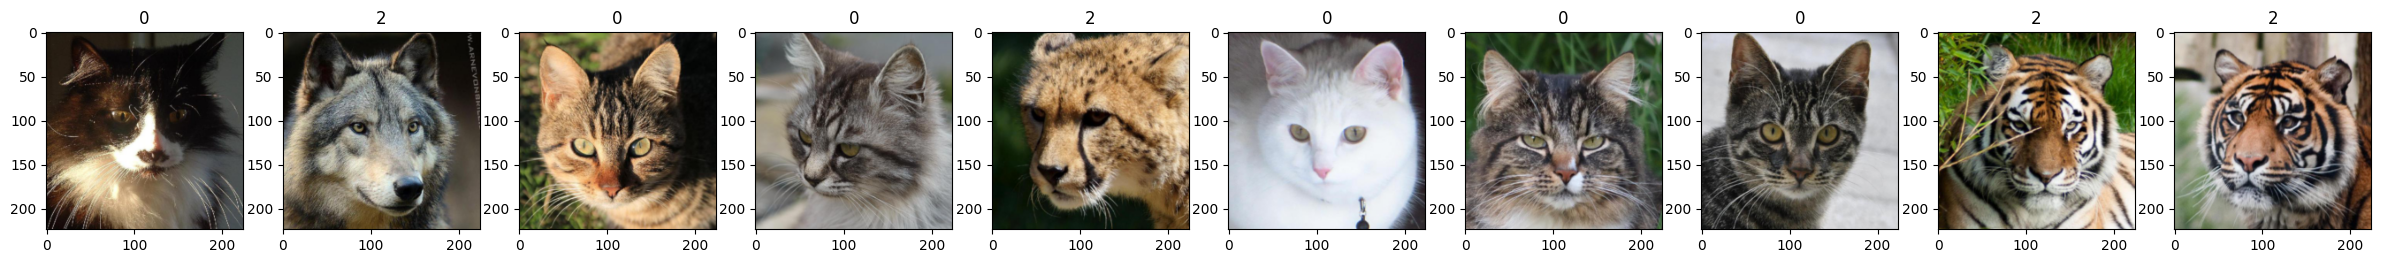

In [ ]:
# отобразим несколько картинок
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        # загружаем изображения как тип ndarray (Height * Width * Channels)
        # будьте внимательны при преобразовании dtype в np.uint8 [целое число (от 0 до 255)].
        # в этом примере я не использую метод ToTensor() из torchvision.transforms
        # поэтому вы можете преобразовать форму numpy ndarray в тензор в PyTorch (H, W, C) --> (C, H, W)
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
        axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

In [ ]:
labels

tensor([0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 1, 2, 0, 1, 0, 0])

# **Обучение сверточной сети**

Наша нейронная сеть будет содержать три слоя: два сверточных и один полносвязный. В качестве функции активации для внутренних слоев будем использовать relu, для последнего слоя -- softmax

In [ ]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# реализуем простую свертночную нейросеть, содержащую 2 сверточных слоя
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3)
        self.conv2 = nn.Conv2d(20, 3, kernel_size=3)
        self.flatten = Flatten()
        self.fc = nn.Linear(145200, 16)

    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        # в качестве функции активации используем ReLU
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        # print(x.size())
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = self.fc(x)
        # print(x.shape)
        return x

In [ ]:
def train(net, n_epoch=2):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch

            # обнуляем градиент
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bаckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()

        # менеджер управления контекстом торча указывает на то, чтобы не обновлять параметры
        with torch.no_grad():
            accuracy = []
            for batch in test_loader:
                x, y = batch
                y_pred = net(x)
                # loss = loss_fn(y_pred, y)
                # находим accuracy батча с теста
                accuracy.append(accuracy_score(y.detach().numpy(), np.argmax(y_pred.detach().numpy(), axis=1)))
            # усредняем accuracy всех батчей на тесте
            accuracy = np.mean(np.array(accuracy))
            # если стало лучше - сохраняем на диск и обновляем лучшую метрику
            if accuracy > best_accuracy:
                print('New best model with test acc:', accuracy)
                torch.save(net.state_dict(), './best_model.pt')
                best_accuracy = accuracy

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 200 батчей
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    print('Обучение закончено')
    return net

In [ ]:
# объявляем сеть
net = ConvNet()

In [ ]:
# обучаем сеть
net = train(net)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/915 [00:00<?, ?it/s]

New best model with test acc: 0.7929964539007093


  0%|          | 0/915 [00:00<?, ?it/s]

New best model with test acc: 0.8158244680851063
Обучение закончено


# **Обучим сверточную сеть на CUDA**

In [ ]:
device = torch.device('cuda')

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.get_device_name()

'Tesla T4'

In [ ]:
def train(net, n_epoch=2):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            # переносим его на видеопамять
            # если точно уверены, что это гпу - можно написать .cuda()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # обнуляем веса
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bsckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()

            # проверяем качество каждые 500 батчей (~пол эпохи)
            if i % 500 ==0:
                # менеджер управления контекстом торча указывает на то, чтобы не обновлять параметры
                with torch.no_grad():
                    accuracy = []
                    for batch in test_loader:
                        x, y = batch
                        # переносим на гпу
                        x = x.to(device)
                        y = y.to(device)
                        # прогнозируем
                        y_pred = net(x)
                        # loss = loss_fn(y_pred, y)
                        # находим accuracy батча с теста
                        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
                    # усредняем accuracy всех батчей на тесте
                    accuracy = np.mean(np.array(accuracy))
                    # если стало лучше - сохраняем на диск и обновляем лучшую метрику
                    if accuracy > best_accuracy:
                        print('New best model with test acc:', accuracy)
                        torch.save(net.state_dict(), './best_model.pt')
                        best_accuracy = accuracy

            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 200 батчей
            if i % 200 == 199:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

    print('Обучение закончено')
    return net

In [ ]:
# объявляем сеть
net = ConvNet().to(device)

In [ ]:
# обучаем
net = train(net, n_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/915 [00:00<?, ?it/s]

New best model with test acc: 0.3377659574468085
[1,   200] loss: 0.929
[1,   400] loss: 0.503
New best model with test acc: 0.8315602836879433
[1,   600] loss: 0.471
[1,   800] loss: 0.412


  0%|          | 0/915 [00:00<?, ?it/s]

New best model with test acc: 0.8705673758865248
[2,   200] loss: 0.229
[2,   400] loss: 0.222
[2,   600] loss: 0.242
[2,   800] loss: 0.227


  0%|          | 0/915 [00:00<?, ?it/s]

[3,   200] loss: 0.088
[3,   400] loss: 0.092
New best model with test acc: 0.8707890070921986
[3,   600] loss: 0.116
[3,   800] loss: 0.128


  0%|          | 0/915 [00:00<?, ?it/s]

New best model with test acc: 0.8765514184397163
[4,   200] loss: 0.042
[4,   400] loss: 0.050
[4,   600] loss: 0.043
[4,   800] loss: 0.052


  0%|          | 0/915 [00:00<?, ?it/s]

[5,   200] loss: 0.025
[5,   400] loss: 0.020
[5,   600] loss: 0.025
[5,   800] loss: 0.043


  0%|          | 0/915 [00:00<?, ?it/s]

[6,   200] loss: 0.019
[6,   400] loss: 0.022
[6,   600] loss: 0.026
[6,   800] loss: 0.050


  0%|          | 0/915 [00:00<?, ?it/s]

[7,   200] loss: 0.015
[7,   400] loss: 0.015
[7,   600] loss: 0.029
[7,   800] loss: 0.042


  0%|          | 0/915 [00:00<?, ?it/s]

[8,   200] loss: 0.024
[8,   400] loss: 0.017
[8,   600] loss: 0.041
[8,   800] loss: 0.021


  0%|          | 0/915 [00:00<?, ?it/s]

[9,   200] loss: 0.007
[9,   400] loss: 0.013
[9,   600] loss: 0.008
[9,   800] loss: 0.032


  0%|          | 0/915 [00:00<?, ?it/s]

[10,   200] loss: 0.005
[10,   400] loss: 0.012
[10,   600] loss: 0.023
[10,   800] loss: 0.015
Обучение закончено


Оценим качество для тестового датасета

In [ ]:
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        # переносим на гпу
        x = x.to(device)
        y = y.to(device)
        # прогнозируем
        y_pred = net(x)
        # loss = loss_fn(y_pred, y)
        # находим accuracy батча с теста
        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
    # усредняем accuracy всех батчей на тесте
    accuracy = np.mean(np.array(accuracy))

print('Test accuracy', accuracy)

Test accuracy 0.8257978723404256


Полученная сверточная нейросеть уже имеет лучшие метрики качества

# **Обучим сверточную нейросеть с аугментацией, skip-connection и конкатенацией внутри отдельных блоков**

Проведу аугментацию изображений датасета, изменение размера изображений, а также нормализацию

In [ ]:
transform_train_augm = transforms.Compose([
    transforms.Resize((224, 224)), # изменим размер изображений на 224х224
    transforms.AutoAugment(),      # применение автоматической аугментации
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # нормализация с использованием средних и стандартных отклонений
])

transform_val_augm = transforms.Compose([
    transforms.Resize((224, 224)), # изменим размер изображений на 224х224
    transforms.ToTensor(),         # применение автоматической аугментации
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # нормализация с использованием средних и стандартных отклонений
])

# загрузка и преобразование тренировочных данных
train_dataset_augm = datasets.ImageFolder(train_path, transform=transform_train_augm)

# загрузка и преобразование валидационных данных
test_dataset_augm = datasets.ImageFolder(val_path, transform=transform_val_augm)


# создание загрузчика данных
train_loader = torch.utils.data.DataLoader(train_dataset_augm,
                                                batch_size=32,
                                                shuffle = True,
                                                pin_memory=True,
                                                num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset_augm,
                                               batch_size=32,
                                               shuffle = False,
                                               pin_memory=True,
                                               num_workers=2)

dataiter = iter(train_loader)
images, labels = next(dataiter)

In [ ]:
# размер картинок
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

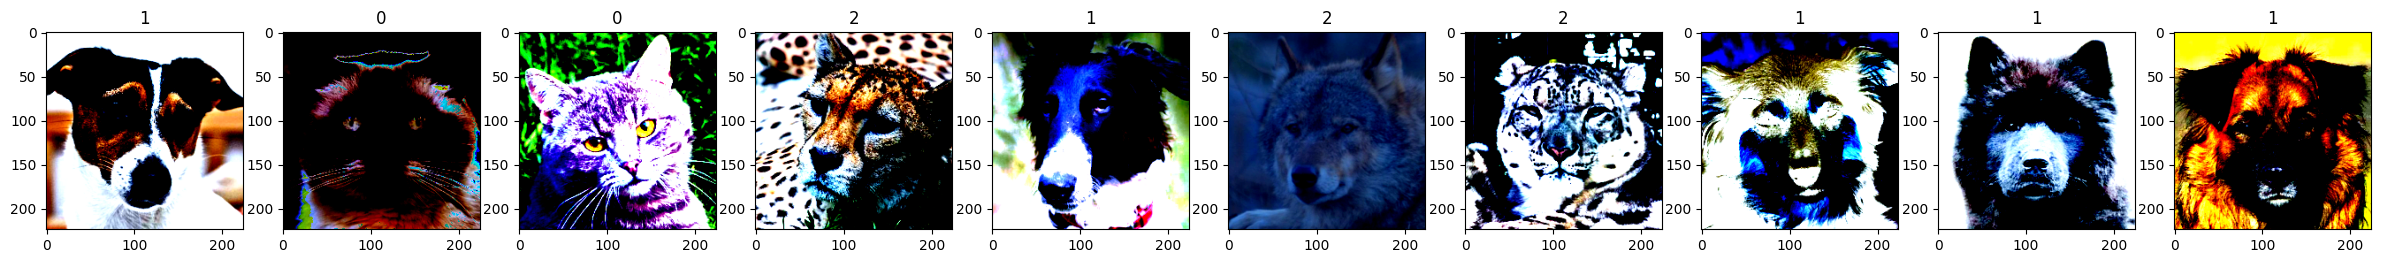

In [ ]:
# посмотрим на некоторые изображения
show_imgs(images, labels)

In [ ]:
class Conv3Pool1_Sum(nn.Module):
    """ Блок свёртки и пулинга со skip-connection и сложением на конце"""
    def __init__(self, in_c, out_c, kernel=3, pad=1, norm=False):
        super().__init__()
        self.conv1 = nn.Sequential(
                      nn.Conv2d( in_channels=in_c,
                                out_channels=out_c,
                                kernel_size=kernel,
                                padding=pad),    # вход 256, 256
                      nn.LeakyReLU(),
                      )
        # инициализация BatchNorm слоя
        self.bn1 = None
        if norm:
            self.bn1 = nn.BatchNorm2d(out_c)
        # создание второго сверточного слоя
        self.conv2 = nn.Sequential(
                      nn.Conv2d( in_channels=out_c, out_channels=out_c, kernel_size=kernel, padding=pad),
                      nn.LeakyReLU(),
                      # nn.BatchNorm2d(out_c)
                      )
        # создание второго сверточного слоя
        self.conv3 = nn.Sequential(
                      nn.Conv2d( in_channels=out_c, out_channels=out_c, kernel_size=kernel, padding=pad),
                      nn.LeakyReLU(),
                      # nn.BatchNorm2d(out_c)
                      )
        # создание слоя пулинга
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # инициализация весов
        self.init_weights()


    def init_weights(self):
      # инициализация весов с помощью метода He
        for l in [self.conv1, self.conv2, self.conv3]:
            # He инициализация весов из нормального распределения
            # по-умолчанию используется Xavier инициализация
            torch.nn.init.kaiming_normal_(l[0].weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')  # a -- коэффициент определяющий наклон левой части ReLU

    def forward(self, x):
        x1 = self.conv1(x)
        if self.bn1:
            x1 = self.bn1(x1)
        x  = self.conv2(x1)
        x2 = self.conv3(x)
        x = x1 + x2
        x = self.pool1(x)
        return x

In [ ]:
class CNN(nn.Module):
    """Сеть с skip-connection и конкатенацией внутри отдельных блоков"""
    def __init__(self, n_classes):
        super().__init__()

        # определим сверточные слои
        self.conv1 = Conv3Pool1_Sum(3,   32)                                             # 128
        self.conv2 = Conv3Pool1_Sum(32,  64)                                             # 64
        self.conv3 = Conv3Pool1_Sum(64,  128)                                             # 32
        self.conv4 = Conv3Pool1_Sum(128, 128, norm=True)                                  # 16

        # определение полносвязных слоев сети
        self.fc1 = nn.Sequential(
                      nn.Linear(in_features=25088, out_features=256, ),
                      nn.Dropout(0.2),
                      nn.LeakyReLU())

        self.fc2_bn =  nn.BatchNorm1d(256)
        self.out = nn.Sequential(
                      nn.Linear(in_features=256, out_features=n_classes),
                      # nn.SoftMax()
                                          )
        # инициализация весов нейронной сети
        self.init_weights()


    def init_weights(self):
        for l in [self.fc1, self.out]:
            # He инициализация весов из нормального распределения
            # по-умолчанию используется Xavier инициализация
            torch.nn.init.kaiming_normal_(l[0].weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')  # a -- коэффициент определяющий наклон левой части ReLU

    def forward(self, x):
        # x = x.view(x.shape[0], 1, 256, 256 )
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # print(x.size())
        x = torch.flatten(x, 1)
        # print(x.size())
        x = self.fc1(x)
        # x = self.fc2(x)
        # if self.training:
        x = self.fc2_bn(x)   # иначе бачнорм на одном объекте упадёт на инференсе
        x = self.out(x)
        return x

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

27507

In [ ]:
# тут 3 - кол-во классов
cnn = CNN(3).to(device)

In [ ]:
params_n = sum(p.numel() for p in cnn.parameters() if p.requires_grad)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-5)

In [ ]:
# обучаем
net = train(cnn, n_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/458 [00:00<?, ?it/s]

New best model with test acc: 0.3332066869300912
[1,   200] loss: 0.998
[1,   400] loss: 0.481


  0%|          | 0/458 [00:00<?, ?it/s]

New best model with test acc: 0.3731952887537994
[2,   200] loss: 0.297
[2,   400] loss: 0.243


  0%|          | 0/458 [00:00<?, ?it/s]

New best model with test acc: 0.3921922492401216
[3,   200] loss: 0.187
[3,   400] loss: 0.167


  0%|          | 0/458 [00:00<?, ?it/s]

[4,   200] loss: 0.133
[4,   400] loss: 0.130


  0%|          | 0/458 [00:00<?, ?it/s]

New best model with test acc: 0.4073898176291793
[5,   200] loss: 0.119
[5,   400] loss: 0.100


  0%|          | 0/458 [00:00<?, ?it/s]

[6,   200] loss: 0.099
[6,   400] loss: 0.098


  0%|          | 0/458 [00:00<?, ?it/s]

[7,   200] loss: 0.089
[7,   400] loss: 0.075


  0%|          | 0/458 [00:00<?, ?it/s]

New best model with test acc: 0.4077697568389058
[8,   200] loss: 0.067
[8,   400] loss: 0.054


  0%|          | 0/458 [00:00<?, ?it/s]

[9,   200] loss: 0.065
[9,   400] loss: 0.066


  0%|          | 0/458 [00:00<?, ?it/s]

New best model with test acc: 0.41004939209726443
[10,   200] loss: 0.067
[10,   400] loss: 0.056
Обучение закончено


# **Файн тюнинг сети**

Наша сверточная сеть не очень хорошо справляется с поставленной задачей. Попробую дообучить сеть VGG16, обученную на ImageNet, под нашу задачу.


In [ ]:
from torchvision import models
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 88.0MB/s]


In [ ]:
vgg16.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [ ]:
# нам не нужен последний слой, обрезаем его
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children()))[:-1]

In [ ]:
# посмотрим на параметры
vgg16.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [ ]:
class New_VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg16 = vgg16 # вся огромная нейросеть в одну строчку
        for param in self.vgg16.features.parameters(): # отключаем для нее обновление параметров
            param.requires_grad = False
        self.fc = nn.Linear(4096, 3) # изменим число выходных нейронов на 3

    def forward(self, x):
        x = self.vgg16(x)
        x = x.view(x.size(0), -1)  # сгладим выход сверточных слоев
        x = self.fc(x)
        #x = F.softmax(x, dim=1)  # применим softmax для нормализации выхода
        return x

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [ ]:
net = New_VGG16().to(device)
train(net, n_epoch=3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/458 [00:00<?, ?it/s]

New best model with test acc: 0.6555851063829787
[1,   200] loss: 1.411
[1,   400] loss: 1.056


  0%|          | 0/458 [00:00<?, ?it/s]

New best model with test acc: 0.9913563829787234
[2,   200] loss: 0.850
[2,   400] loss: 0.621


  0%|          | 0/458 [00:00<?, ?it/s]

New best model with test acc: 0.992686170212766
[3,   200] loss: 0.458
[3,   400] loss: 0.628
Обучение закончено


New_VGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

Результаты работы обученной сети VGG16 заметно лучше. Проверим ее на тестовом датасете

In [ ]:
test_dataiter = iter(test_loader)
images, labels = next(test_dataiter)

In [ ]:
# размер датасета
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

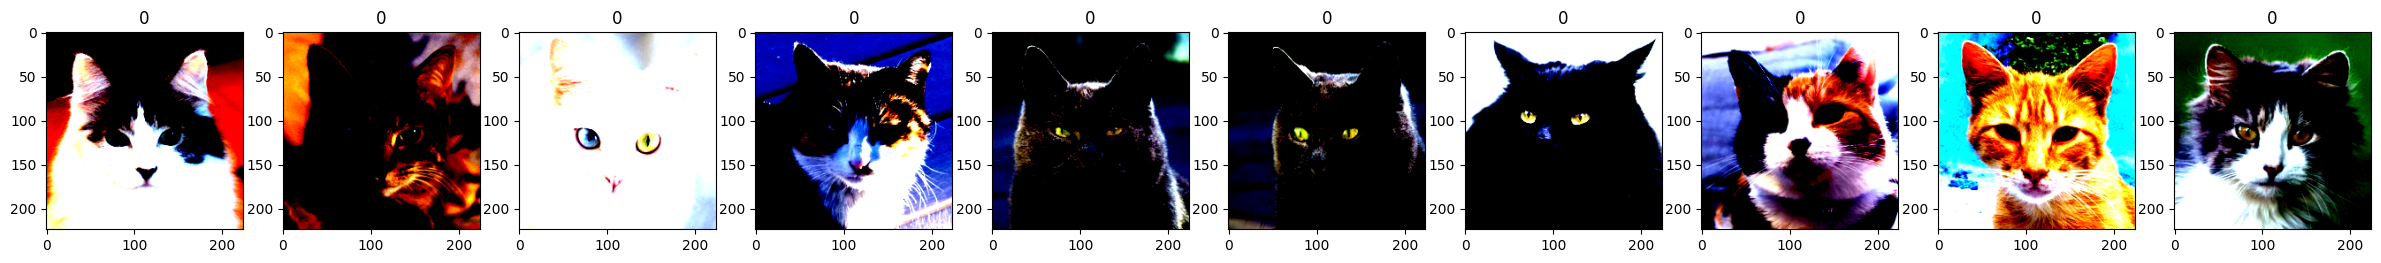

In [ ]:
# посмотрим на некоторые изображения
show_imgs(images, labels)

In [ ]:
labels_net = []  # список для хранения предсказанных меток
labels_true = [] # список для хранения истинных меток
images_list = [] # список для хранения изображений

for images, labels in test_loader:
    images_list.extend(images)
    labels_true.extend(labels)
    labels_net.extend(net.forward(images.cuda()).detach().cpu().numpy())

Оценим модель на тестовой выборке

In [ ]:
accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

0.996

Модель отлично предсказывает классы на тестовой выборке

# Оценка модели

Оценим модель по метрикам качества для каждого класса в тестовом датасете

Classification Report:
                precision    recall  f1-score   support

         Кошка       1.00      1.00      1.00       500
        Собака       1.00      0.99      1.00       500
Дикое животное       0.99      1.00      0.99       500

      accuracy                           1.00      1500
     macro avg       1.00      1.00      1.00      1500
  weighted avg       1.00      1.00      1.00      1500



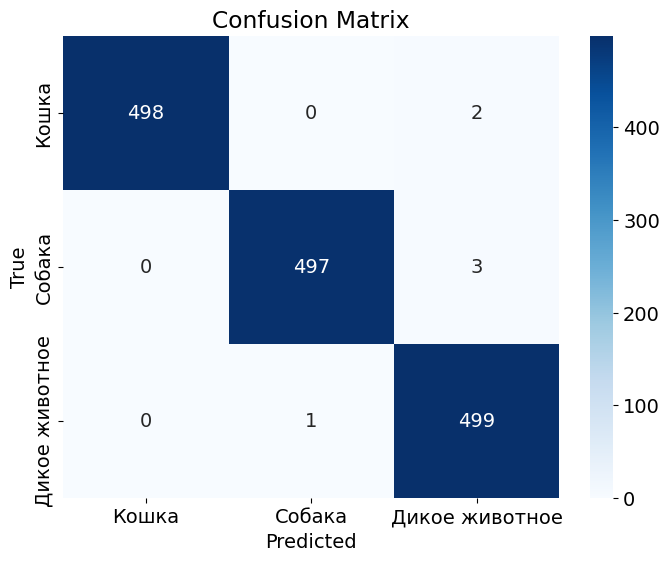

In [ ]:
# Преобразование предсказанных меток в индексы класса
labels_pred = [np.argmax(label) for label in labels_net]

# Classification report
classification_rep = classification_report(labels_true, labels_pred, target_names=num_to_name.values())
print("Classification Report:")
print(classification_rep)

# Confusion matrix
cm = confusion_matrix(labels_true, labels_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=num_to_name.values(), yticklabels=num_to_name.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Отобразим несколько картинок и предсказаний к ним для каждого класса



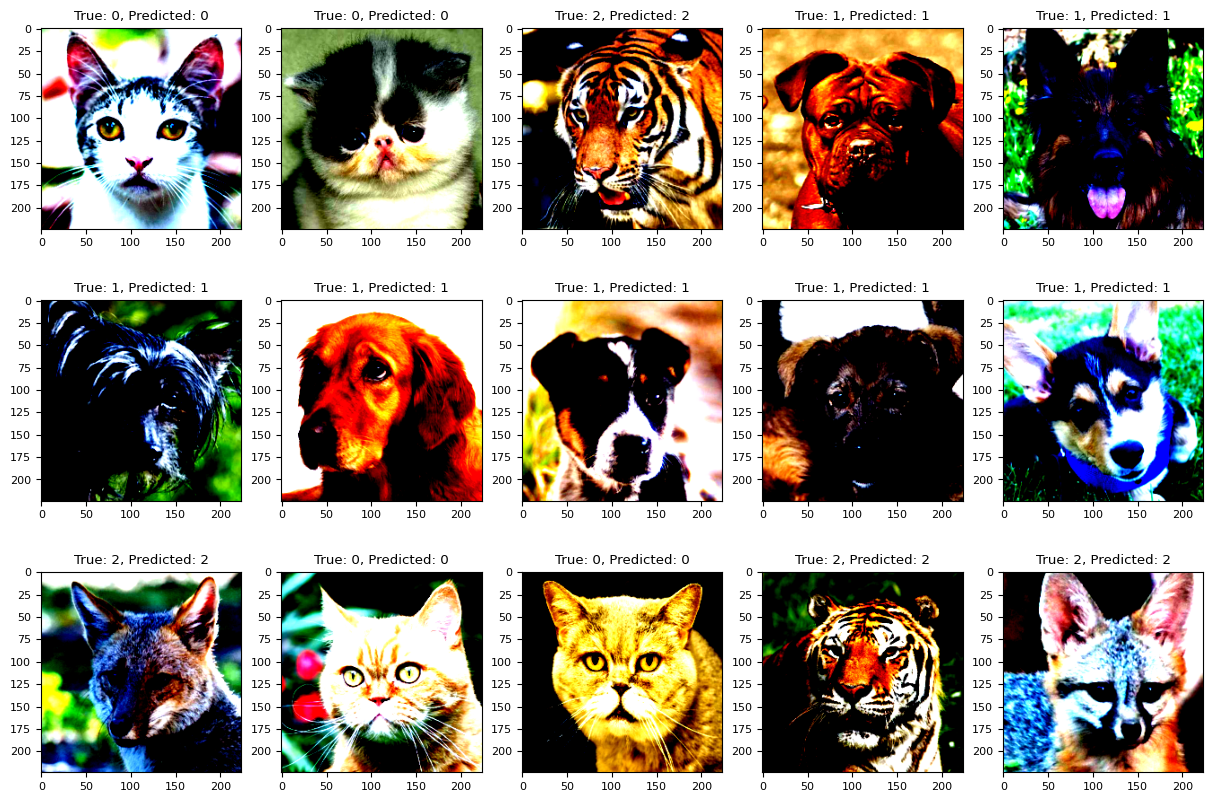

In [ ]:
import random

# выбираем 15 случайных картинок
rand_indices = random.sample(range(len(images_list)), 15)

# отобразим случайные изображения
def show_imgs_with_pred(images_list, labels_true, labels_pred, indices):
    plt.rcParams.update({'font.size': 8})
    f, axes= plt.subplots(3, 5, figsize=(15,10))
    axes = axes.ravel()
    for i, idx in enumerate(indices):
        axes[i].imshow(np.squeeze(np.transpose(images_list[idx].numpy(), (1, 2, 0))), cmap='gray')
        title = f'True: {labels_true[idx]}, Predicted: {labels_pred[idx]}'
        axes[i].set_title(title)
    plt.show()

show_imgs_with_pred(images_list, labels_true, labels_pred, rand_indices)

Как мы видим по картинкам истинные значения и предсказанные значения совпадают и соответствуют картинкам. Алгоритм работает отлично